In [1]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from datetime import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


import os
import yfinance as yf
from pandas_datareader import data as pdr

<ipython-input-1-d77eedebf078>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [110]:
df = pd.read_csv("https://github.com/yashMangal19/sem6_files/blob/main/df1.csv?raw=true")
df.head()

,Date,Title,URL,sentiment,confidence,Text
0,2017-01-03,​Meenakshi Dawar and Varun Goel join Reliance ...,http://economictimes.indiatimes.com/mf/mf-news...,NEGATIVE,-0.838119,Get ready for some fund manager churning. Meen...
1,2017-01-03,"Will follow Reliance Jio pricing , says Bharti...",http://www.financialexpress.com/industry/will-...,NEGATIVE,-0.925142,The Financial ExpressBharti Airtel chairman Su...
2,2017-01-04,Reliance Jio Prime membership plan extended ti...,http://www.financialexpress.com/industry/techn...,POSITIVE,0.794206,The Financial ExpressReliance Jio has announce...
3,2017-01-06,"Reliance Retail : Ladies , now de",http://economictimes.indiatimes.com/industry/s...,POSITIVE,0.964752,MUMBAI: Reliance Retail is launching stores wh...
4,2017-01-06,Internet Trends Report highlights India mobile...,http://www.livemint.com/Technology/ssczejSaUSV...,NEGATIVE,-0.993098,New Delhi: The volume of wireless broadband da...


In [96]:
dates = df["Date"].values

In [97]:
def get_next_day_prices(date):
    stock = yf.Ticker("RELIANCE.NS")
    next_day = date
    while True:
        hist = stock.history(start=next_day, end=next_day + pd.DateOffset(days=1))
        if not hist.empty:
            close_price = hist.iloc[0]['Close']
            return close_price
        next_day += pd.DateOffset(days=1)

In [98]:
d = {}
stock = []
for date in dates:
  if date not in d:
    stock.append([date, get_next_day_prices(datetime.datetime.strptime(date, "%Y-%m-%d"))])
    d[date] = 1

ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-01-07 00:00:00 -> 2017-01-08 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-01-08 00:00:00 -> 2017-01-09 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-01-08 00:00:00 -> 2017-01-09 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-02-19 00:00:00 -> 2017-02-20 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-02-24 00:00:00 -> 2017-02-25 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-02-25 00:00:00 -> 2017-02-26 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-02-26 00:00:00 -> 2017-02-27 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price data found, symbol may be delisted (1d 2017-03-04 00:00:00 -> 2017-03-05 00:00:00)
ERROR:yfinance:RELIANCE.NS: No price dat

In [99]:
stock = pd.DataFrame(stock)
stock.head()

,0,1
0,2017-01-03,480.960114
1,2017-01-04,471.136963
2,2017-01-06,474.580597
3,2017-01-07,475.794708
4,2017-01-08,475.794708


In [100]:
stock.columns = ["date", "close"]
stock.head()

,date,close
0,2017-01-03,480.960114
1,2017-01-04,471.136963
2,2017-01-06,474.580597
3,2017-01-07,475.794708
4,2017-01-08,475.794708


In [101]:
scaler = MinMaxScaler(feature_range=(-1, 1))
stock['close'] = scaler.fit_transform(stock['close'].values.reshape(-1,1))
stock.head()

,date,close
0,2017-01-03,-0.966391
1,2017-01-04,-0.976763
2,2017-01-06,-0.973127
3,2017-01-07,-0.971845
4,2017-01-08,-0.971845


In [102]:
stock

,date,close
0,2017-01-03,-0.966391
1,2017-01-04,-0.976763
2,2017-01-06,-0.973127
3,2017-01-07,-0.971845
4,2017-01-08,-0.971845
...,...,...
760,2021-09-02,0.746641
761,2021-09-03,0.837725
762,2021-10-01,0.968590
763,2021-10-02,1.000000


In [103]:
stock = stock[['close']]

In [104]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 100 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (532, 99, 1)
y_train.shape =  (532, 1)
x_test.shape =  (133, 99, 1)
y_test.shape =  (133, 1)


In [105]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [106]:
y_train.size(),x_train.size()

(torch.Size([532, 1]), torch.Size([532, 99, 1]))

In [107]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [108]:
# Train model
#####################
num_epochs = 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.052687305957078934
Epoch  20 MSE:  0.017311453819274902
Epoch  30 MSE:  0.004835535306483507
Epoch  40 MSE:  0.0035239735152572393
Epoch  50 MSE:  0.0027109733782708645
Epoch  60 MSE:  0.002118782140314579
Epoch  70 MSE:  0.0018682052614167333
Epoch  80 MSE:  0.0017122139688581228
Epoch  90 MSE:  0.0015919178258627653
Epoch  100 MSE:  0.001493516145274043
Epoch  110 MSE:  0.0014122753636911511
Epoch  120 MSE:  0.0013491612626239657
Epoch  130 MSE:  0.001303233439102769
Epoch  140 MSE:  0.001265177153982222
Epoch  150 MSE:  0.0012308815494179726
Epoch  160 MSE:  0.0011992987710982561
Epoch  170 MSE:  0.0011695101857185364
Epoch  180 MSE:  0.0011410173028707504
Epoch  190 MSE:  0.0011136408429592848
Epoch  200 MSE:  0.0010873290011659265
Epoch  210 MSE:  0.0014921873807907104
Epoch  220 MSE:  0.001121697248890996
Epoch  230 MSE:  0.0010929139098152518
Epoch  240 MSE:  0.001060495269484818
Epoch  250 MSE:  0.001015587244182825
Epoch  260 MSE:  0.0009935813723132014
Epoch

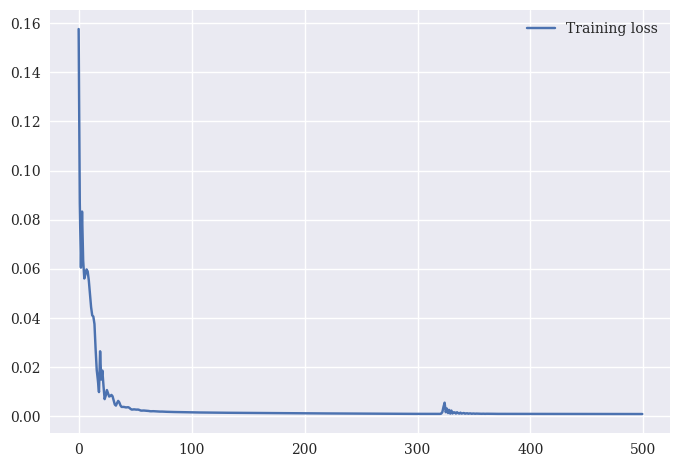

In [58]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [59]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 27.30 RMSE
Test Score: 70.78 RMSE


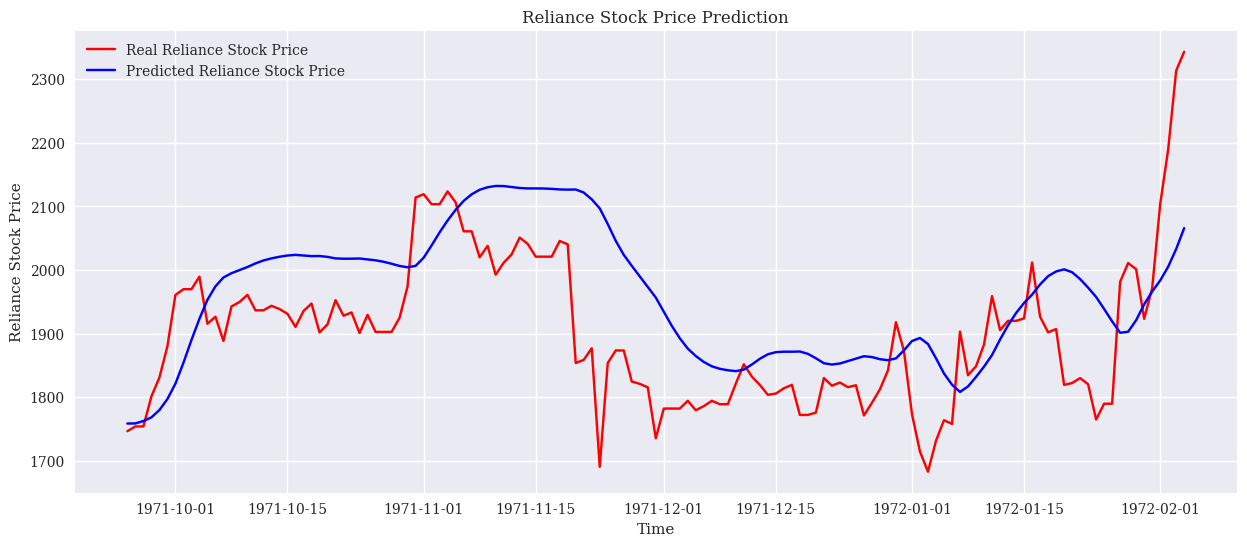

In [49]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(stock[len(stock)-len(y_test):].index, y_test, color = 'red', label = 'Real Reliance Stock Price')
axes.plot(stock[len(stock)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Reliance Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Reliance Stock Price')
plt.legend()
plt.show()

In [138]:
sms = []
for date, group in df.groupby('Date'):
  cons = list(group['confidence'])
  # wes = list(group['weight'])
  s = 0
  for i in range(len(cons)):
    s += cons[i]

  sms.append(s)

In [139]:
stock['sentiment'] = np.array(sms).reshape(-1,1)
stock.head()

,close,sentiment
0,-0.966391,-1.763262
1,-0.976763,0.794206
2,-0.973127,-0.028346
3,-0.971845,-1.778350
4,-0.971845,0.988136


In [140]:
scaler2 = MinMaxScaler(feature_range=(-1, 1))
stock['sentiment'] = scaler2.fit_transform(stock['sentiment'].values.reshape(-1,1))
stock.head()

,close,sentiment
0,-0.966391,-0.412031
1,-0.976763,-0.091713
2,-0.973127,-0.194736
3,-0.971845,-0.413921
4,-0.971845,-0.067424


In [146]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train_close = data[:train_set_size, :, 0]  # Closing prices for training
    x_train_sentiment = data[:train_set_size, -1, 1]  # Sentiment for training
    y_train = data[:train_set_size, -1, 0]  # Target (next day's closing price) for training

    x_test_close = data[train_set_size:, :, 0]  # Closing prices for testing
    x_test_sentiment = data[train_set_size:, -1, 1]  # Sentiment for testing
    y_test = data[train_set_size:, -1, 0]  # Target (next day's closing price) for testing

    return (x_train_close, x_train_sentiment, y_train, x_test_close, x_test_sentiment, y_test)

look_back = 100  # choose sequence length
x_train_close, x_train_sentiment, y_train, x_test_close, x_test_sentiment, y_test = load_data(stock, look_back)

print('x_train_close.shape =', x_train_close.shape)
print('x_train_sentiment.shape =', x_train_sentiment.shape)
print('y_train.shape =', y_train.shape)
print('x_test_close.shape =', x_test_close.shape)
print('x_test_sentiment.shape =', x_test_sentiment.shape)
print('y_test.shape =', y_test.shape)

x_train_close.shape = (532, 100)
x_train_sentiment.shape = (532,)
y_train.shape = (532,)
x_test_close.shape = (133, 100)
x_test_sentiment.shape = (133,)
y_test.shape = (133,)


In [147]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, sentiment_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim + sentiment_dim, output_dim)

    def forward(self, x, sentiment):
        _, (hn, _) = self.lstm(x)

        # Select the hidden state of the last time step
        hn = hn[-1]

        # Unsqueeze the sentiment tensor along the batch dimension
        sentiment = sentiment.unsqueeze(1)

        # Concatenate sentiment with the output of LSTM
        combined = torch.cat((hn, sentiment), dim=1)

        # Apply linear transformation
        out = self.fc(combined)

        return out

# Assuming sentiment_dim is the dimension of the sentiment feature
input_dim = 1
sentiment_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

model = LSTM(input_dim=input_dim, sentiment_dim=sentiment_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert data to torch tensors
x_train_close_tensor = torch.from_numpy(x_train_close).float().unsqueeze(2)  # Add a new dimension for sequence length
x_train_sentiment_tensor = torch.from_numpy(x_train_sentiment).float()  # No need to add a new dimension for sentiment
y_train_tensor = torch.from_numpy(y_train).float()

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_close_tensor, x_train_sentiment_tensor)
    loss = loss_fn(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.0710
Epoch [20/500], Loss: 0.0417
Epoch [30/500], Loss: 0.0134
Epoch [40/500], Loss: 0.0049
Epoch [50/500], Loss: 0.0025
Epoch [60/500], Loss: 0.0017
Epoch [70/500], Loss: 0.0012
Epoch [80/500], Loss: 0.0010
Epoch [90/500], Loss: 0.0009
Epoch [100/500], Loss: 0.0008
Epoch [110/500], Loss: 0.0007
Epoch [120/500], Loss: 0.0007
Epoch [130/500], Loss: 0.0006
Epoch [140/500], Loss: 0.0006
Epoch [150/500], Loss: 0.0006
Epoch [160/500], Loss: 0.0005
Epoch [170/500], Loss: 0.0005
Epoch [180/500], Loss: 0.0005
Epoch [190/500], Loss: 0.0004
Epoch [200/500], Loss: 0.0004
Epoch [210/500], Loss: 0.0004
Epoch [220/500], Loss: 0.0003
Epoch [230/500], Loss: 0.0003
Epoch [240/500], Loss: 0.0003
Epoch [250/500], Loss: 0.0003
Epoch [260/500], Loss: 0.0002
Epoch [270/500], Loss: 0.0002
Epoch [280/500], Loss: 0.0002
Epoch [290/500], Loss: 0.0001
Epoch [300/500], Loss: 0.0001
Epoch [310/500], Loss: 0.0001
Epoch [320/500], Loss: 0.0001
Epoch [330/500], Loss: 0.0001
Epoch [340/500], Lo

In [148]:
# Convert data to torch tensors
x_train_close_tensor = torch.from_numpy(x_train_close).float().unsqueeze(2)  # Add a new dimension for sequence length
x_train_sentiment_tensor = torch.from_numpy(x_train_sentiment).float()  # No need to add a new dimension for sentiment
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)  # Add a new dimension for the target feature

# Make predictions for the training set
y_train_pred = model(x_train_close_tensor, x_train_sentiment_tensor)

# Invert predictions and true values for the training set
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_true = scaler.inverse_transform(y_train_tensor.detach().numpy())

# Calculate root mean squared error for the training set
train_score = math.sqrt(mean_squared_error(y_train_true[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % train_score)

# Convert data to torch tensors for the testing set
x_test_close_tensor = torch.from_numpy(x_test_close).float().unsqueeze(2)  # Add a new dimension for sequence length
x_test_sentiment_tensor = torch.from_numpy(x_test_sentiment).float()  # No need to add a new dimension for sentiment
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)  # Add a new dimension for the target feature

# Make predictions for the testing set
y_test_pred = model(x_test_close_tensor, x_test_sentiment_tensor)

# Invert predictions and true values for the testing set
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_true = scaler.inverse_transform(y_test_tensor.detach().numpy())

# Calculate root mean squared error for the testing set
test_score = math.sqrt(mean_squared_error(y_test_true[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

Train Score: 1.87 RMSE
Test Score: 35.14 RMSE


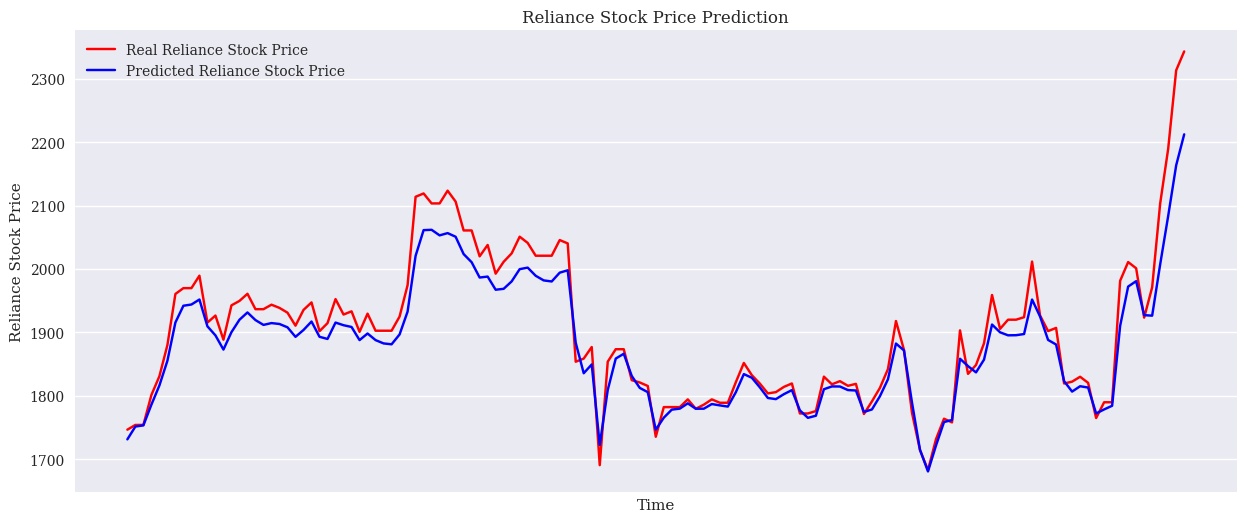

In [149]:
# Convert the index of the stock dataframe to datetime if it's not already in datetime format
stock.index = pd.to_datetime(stock.index)

# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(stock.index[-len(y_test):], y_test_true, color='red', label='Real Reliance Stock Price')
plt.plot(stock.index[-len(y_test):], y_test_pred, color='blue', label='Predicted Reliance Stock Price')
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Reliance Stock Price')
plt.legend()
plt.show()

In [109]:
df2 = pd.read_csv('https://github.com/yashMangal19/sem6_files/blob/main/df2.csv?raw=true')
df2

,Date,Title,URL,sentiment,confidence,Text,pct,pred,weight
0,2017-01-03,​Meenakshi Dawar and Varun Goel join Reliance ...,http://economictimes.indiatimes.com/mf/mf-news...,NEGATIVE,-0.838119,Get ready for some fund manager churning. Meen...,-0.041295,-0.013765,0.587823
1,2017-01-03,"Will follow Reliance Jio pricing , says Bharti...",http://www.financialexpress.com/industry/will-...,NEGATIVE,-0.925142,The Financial ExpressBharti Airtel chairman Su...,-0.041295,-0.013765,0.544311
2,2017-01-04,Reliance Jio Prime membership plan extended ti...,http://www.financialexpress.com/industry/techn...,POSITIVE,0.794206,The Financial ExpressReliance Jio has announce...,-2.356117,-0.785372,0.210211
3,2017-01-06,"Reliance Retail : Ladies , now de",http://economictimes.indiatimes.com/industry/s...,POSITIVE,0.964752,MUMBAI: Reliance Retail is launching stores wh...,0.069817,0.023272,0.529260
4,2017-01-06,Internet Trends Report highlights India mobile...,http://www.livemint.com/Technology/ssczejSaUSV...,NEGATIVE,-0.993098,New Delhi: The volume of wireless broadband da...,0.069817,0.023272,0.491815
...,...,...,...,...,...,...,...,...,...
1704,2021-09-03,Jio launches special JioFiber Business plans f...,https://www.businesstoday.in/technology/jio-la...,POSITIVE,0.884634,Reliance Jio on Tuesday announced integrated J...,3.398273,1.000000,0.942317
1705,2021-10-01,"With Improvement In Macros , Nifty Earnings Ex...",https://www.moneycontrol.com/news/business/mar...,POSITIVE,0.984251,"After a strong quarter of Q2FY21 earnings, the...",0.869320,0.289773,0.652761
1706,2021-10-02,"4G Auctions : Jio , Airtel , Vi to participate",https://economictimes.indiatimes.com/markets/s...,POSITIVE,0.701238,"MUMBAI: Telecom market leader Reliance Jio, se...",0.123385,0.041128,0.669945
1707,2021-10-02,"4G auctions : Jio , Airtel , Vodafone Idea to ...",https://economictimes.indiatimes.com/industry/...,POSITIVE,0.828440,"Telecom market leader Reliance Jio, second-ran...",0.123385,0.041128,0.606344


In [164]:
sms = []
for date, group in df2.groupby('Date'):
  cons = list(group['confidence'])
  wes = list(group['weight'])
  s = 0
  for i in range(len(cons)):
    s += cons[i]*wes[i]

  sms.append(s)

In [166]:
stock['sentiment'] = np.array(sms).reshape(-1,1)
stock.head()

,close,sentiment
1970-01-01 00:00:00.000000000,-0.966391,-0.996231
1970-01-01 00:00:00.000000001,-0.976763,0.166951
1970-01-01 00:00:00.000000002,-0.973127,0.022185
1970-01-01 00:00:00.000000003,-0.971845,-0.964397
1970-01-01 00:00:00.000000004,-0.971845,0.510633


In [169]:
scaler3 = MinMaxScaler(feature_range=(-1, 1))
stock['sentiment'] = scaler3.fit_transform(stock['sentiment'].values.reshape(-1,1))
stock.head()

,close,sentiment
1970-01-01 00:00:00.000000000,-0.966391,-0.633501
1970-01-01 00:00:00.000000001,-0.976763,-0.473831
1970-01-01 00:00:00.000000002,-0.973127,-0.493703
1970-01-01 00:00:00.000000003,-0.971845,-0.629131
1970-01-01 00:00:00.000000004,-0.971845,-0.426654


In [170]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train_close = data[:train_set_size, :, 0]  # Closing prices for training
    x_train_sentiment = data[:train_set_size, -1, 1]  # Sentiment for training
    y_train = data[:train_set_size, -1, 0]  # Target (next day's closing price) for training

    x_test_close = data[train_set_size:, :, 0]  # Closing prices for testing
    x_test_sentiment = data[train_set_size:, -1, 1]  # Sentiment for testing
    y_test = data[train_set_size:, -1, 0]  # Target (next day's closing price) for testing

    return (x_train_close, x_train_sentiment, y_train, x_test_close, x_test_sentiment, y_test)

look_back = 100  # choose sequence length
x_train_close, x_train_sentiment, y_train, x_test_close, x_test_sentiment, y_test = load_data(stock, look_back)

print('x_train_close.shape =', x_train_close.shape)
print('x_train_sentiment.shape =', x_train_sentiment.shape)
print('y_train.shape =', y_train.shape)
print('x_test_close.shape =', x_test_close.shape)
print('x_test_sentiment.shape =', x_test_sentiment.shape)
print('y_test.shape =', y_test.shape)

x_train_close.shape = (532, 100)
x_train_sentiment.shape = (532,)
y_train.shape = (532,)
x_test_close.shape = (133, 100)
x_test_sentiment.shape = (133,)
y_test.shape = (133,)


In [171]:
# Assuming sentiment_dim is the dimension of the sentiment feature
input_dim = 1
sentiment_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

model = LSTM(input_dim=input_dim, sentiment_dim=sentiment_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert data to torch tensors
x_train_close_tensor = torch.from_numpy(x_train_close).float().unsqueeze(2)  # Add a new dimension for sequence length
x_train_sentiment_tensor = torch.from_numpy(x_train_sentiment).float()  # No need to add a new dimension for sentiment
y_train_tensor = torch.from_numpy(y_train).float()

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_close_tensor, x_train_sentiment_tensor)
    loss = loss_fn(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.0051
Epoch [20/500], Loss: 0.0056
Epoch [30/500], Loss: 0.0022
Epoch [40/500], Loss: 0.0012
Epoch [50/500], Loss: 0.0010
Epoch [60/500], Loss: 0.0007
Epoch [70/500], Loss: 0.0006
Epoch [80/500], Loss: 0.0005
Epoch [90/500], Loss: 0.0004
Epoch [100/500], Loss: 0.0004
Epoch [110/500], Loss: 0.0004
Epoch [120/500], Loss: 0.0003
Epoch [130/500], Loss: 0.0003
Epoch [140/500], Loss: 0.0003
Epoch [150/500], Loss: 0.0002
Epoch [160/500], Loss: 0.0002
Epoch [170/500], Loss: 0.0002
Epoch [180/500], Loss: 0.0002
Epoch [190/500], Loss: 0.0001
Epoch [200/500], Loss: 0.0001
Epoch [210/500], Loss: 0.0001
Epoch [220/500], Loss: 0.0001
Epoch [230/500], Loss: 0.0001
Epoch [240/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [260/500], Loss: 0.0000
Epoch [270/500], Loss: 0.0000
Epoch [280/500], Loss: 0.0000
Epoch [290/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [310/500], Loss: 0.0000
Epoch [320/500], Loss: 0.0000
Epoch [330/500], Loss: 0.0000
Epoch [340/500], Lo

In [172]:
# Convert data to torch tensors
x_train_close_tensor = torch.from_numpy(x_train_close).float().unsqueeze(2)  # Add a new dimension for sequence length
x_train_sentiment_tensor = torch.from_numpy(x_train_sentiment).float()  # No need to add a new dimension for sentiment
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)  # Add a new dimension for the target feature

# Make predictions for the training set
y_train_pred = model(x_train_close_tensor, x_train_sentiment_tensor)

# Invert predictions and true values for the training set
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_true = scaler.inverse_transform(y_train_tensor.detach().numpy())

# Calculate root mean squared error for the training set
train_score = math.sqrt(mean_squared_error(y_train_true[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % train_score)

# Convert data to torch tensors for the testing set
x_test_close_tensor = torch.from_numpy(x_test_close).float().unsqueeze(2)  # Add a new dimension for sequence length
x_test_sentiment_tensor = torch.from_numpy(x_test_sentiment).float()  # No need to add a new dimension for sentiment
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)  # Add a new dimension for the target feature

# Make predictions for the testing set
y_test_pred = model(x_test_close_tensor, x_test_sentiment_tensor)

# Invert predictions and true values for the testing set
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_true = scaler.inverse_transform(y_test_tensor.detach().numpy())

# Calculate root mean squared error for the testing set
test_score = math.sqrt(mean_squared_error(y_test_true[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

Train Score: 0.95 RMSE
Test Score: 14.63 RMSE


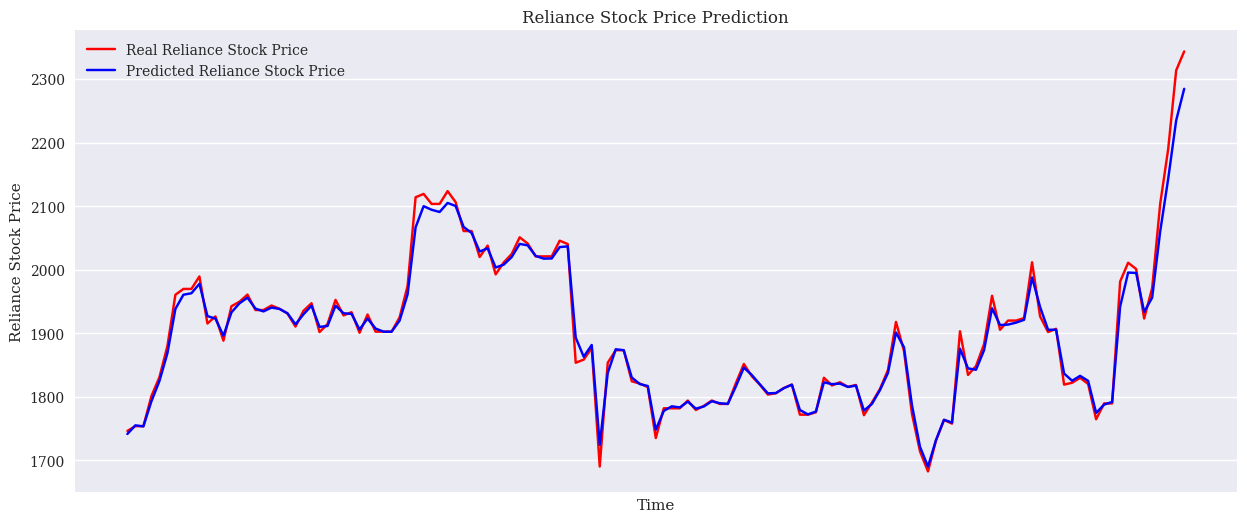

In [173]:
# Convert the index of the stock dataframe to datetime if it's not already in datetime format
stock.index = pd.to_datetime(stock.index)

# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(stock.index[-len(y_test):], y_test_true, color='red', label='Real Reliance Stock Price')
plt.plot(stock.index[-len(y_test):], y_test_pred, color='blue', label='Predicted Reliance Stock Price')
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Reliance Stock Price')
plt.legend()
plt.show()